In [1]:
from matplotlib import pyplot as plt

In [2]:
import torch
from ppuu.data.dataloader import Dataset, DataStore
from torch.utils.data import DataLoader

# ds_path = "/misc/vlgscratch4/LecunGroup/nvidia-collab/traffic-data_offroad/state-action-cost/data_i80_v0/"
# ds_path = "/misc/vlgscratch4/LecunGroup/nvidia-collab/vlad/traffic-data_offroad_50_test_train_same/state-action-cost/data_i80_v0/"
ds_path = "/home/us441/nvidia-collab/vlad/traffic-data-5-small/state-action-cost/data_i80_v0/"

data_store = DataStore(ds_path)

dataset = Dataset(
    data_store, "val", 20, 30, size=1000, normalize=True, shift=False, random_actions=False,
)

loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=0,
)


batch = next(iter(loader))

In [3]:
liter = iter(loader)

In [4]:
batch = next(liter)

In [5]:
from ppuu.costs import PolicyCost
from ppuu.costs import PolicyCostKMTaper
from ppuu.costs import PolicyCostContinuous
from ppuu.data.dataloader import Normalizer
normalizer = Normalizer(data_store.stats)
config = PolicyCostKMTaper.Config()
cost = PolicyCostKMTaper(config, None, Normalizer(data_store.stats))
# config = PolicyCost.Config()
# cost = PolicyCost(config, None, data_store.stats)

In [6]:
p_cost = cost.compute_proximity_cost(batch['input_images'], batch['input_states'], batch['car_sizes'], unnormalize=True)

In [7]:
p_cost['costs']

tensor([[0.0094, 0.0087, 0.0086, 0.0085, 0.0067, 0.0045, 0.0042, 0.0031, 0.0029,
         0.0032, 0.0024, 0.0027, 0.0023, 0.0022, 0.0023, 0.0022, 0.0020, 0.0020,
         0.0021, 0.0020]])

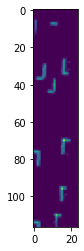

In [8]:
plt.imshow(p_cost['contours'][0][0])

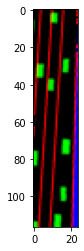

In [9]:
from matplotlib import pyplot as plt
plt.imshow(batch['input_images'][0][0].permute(1, 2, 0).detach())

In [10]:
image = batch['input_images'][0][0]
actions = batch['actions'][0][0]
states = batch['input_states'][0][0]
car_sizes = batch['car_sizes'][0]

In [25]:
def shift(image, x, y):
    new_image = torch.roll(image, (x, y), (1, 2)).clone()
    if y >= 0:
        new_image[:, :, :y] = 0
    else:
        new_image[:, :, y:] = 0
    if x >= 0:
        new_image[:, :x, :] = 0
    else:
        new_image[:, x:, :] = 0
    return new_image

In [26]:
def get_results(cost):
    results = torch.zeros(image.shape[1:])
    center_x = results.shape[0] // 2 + 1
    center_y = results.shape[1] // 2 + 1
    
    for x in range(results.shape[0]):
        for y in range(results.shape[1]):
            shift_x = center_x - x
            shift_y = center_y - y
            s_image = shift(image, shift_x, shift_y)
            # p_cost = cost.compute_proximity_cost(s_image.unsqueeze(0).unsqueeze(0), states.unsqueeze(0), car_sizes.unsqueeze(0), unnormalize=True)
            p_cost = cost.compute_state_costs_for_training(None, s_image.unsqueeze(0).unsqueeze(0).cuda(), states.cuda().unsqueeze(0), actions.cuda().unsqueeze(0), car_sizes.unsqueeze(0))
            results[x][y] = p_cost['proximity_loss']
    return results

In [28]:
config_old = PolicyCost.Config()
cost_old = PolicyCost(config, None, normalizer)

config_cont = PolicyCostContinuous.Config()
config_cont.masks_power_x = 2
config_cont.masks_power_y = 2
config_cont.skip_contours = True
config_cont.safe_factor = 2
cost_cont = PolicyCostContinuous(config_cont, None, normalizer)

res_old = get_results(cost_old)
res_cont = get_results(cost_cont)

In [29]:
config_new = PolicyCostKMTaper.Config()
config_new.masks_power_x = 2
config_new.masks_power_y = 2
config_new.safe_factor = 1.5
config_new.skip_contours = True
cost_new = PolicyCostKMTaper(config_new, None, normalizer)
res_new = get_results(cost_new)

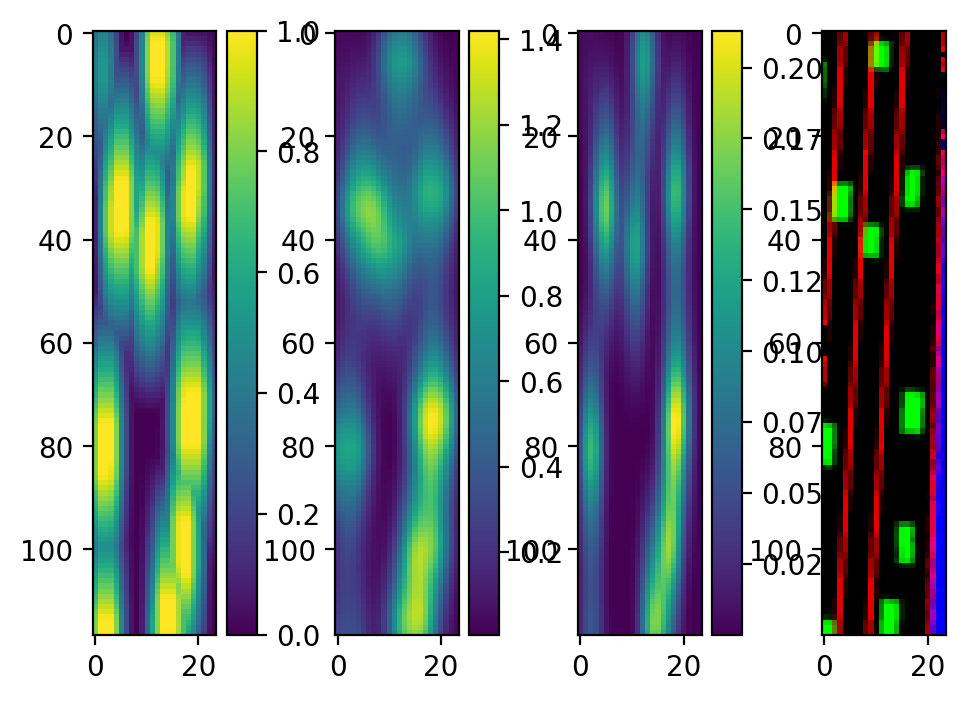

In [30]:
plt.figure(dpi=200)
plt.subplot(1, 4, 1)
plt.imshow(res_old)
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(res_new)
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(res_cont)
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(image.permute(1, 2, 0))

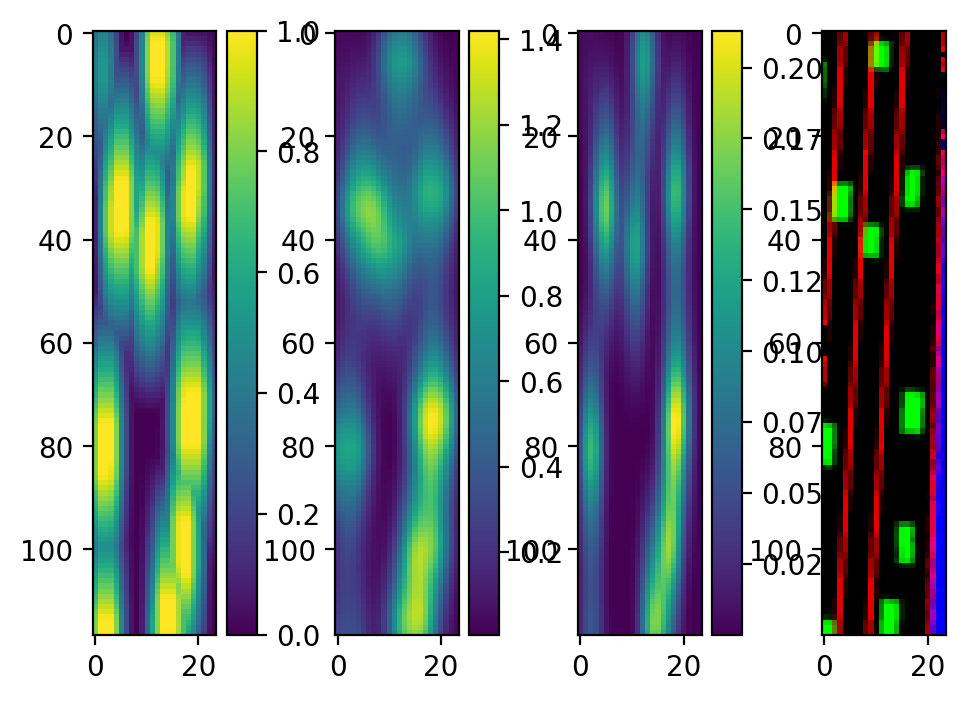

In [31]:
plt.figure(dpi=200)
plt.subplot(1, 4, 1)
plt.imshow(res_old)
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(res_new)
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(res_cont)
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(image.permute(1, 2, 0))